## Automated Machine Learning Pipeline
        

This notebook is a template for creating an end-to-end machine learning pipeline which aims to automate the process of data preprocessing, feature engineering, model selection, and model evaluation. The pipeline is built using the following steps:
The pipeline includes the following steps:

- 0. Importing libraries
- 1. Load the dataset
- 2. Indexing and Label Encoding it.
- 3. Initialize Entity Set for Data Type Handling and Process
- 4. Categorize Columns on the basis of Data Type
- 5. Remove Unnecessary Columns by the User.
- 6. Remove Single Unique Value Columns and High Cardinality Columns(int type only)
- 7. Impute Missing Values
- 8. Split Columns with Comma
- 9. Apply Transformation on Columns
- 10. Label Encoding on Categorical Columns(including target column)
- 11. Remove Highly Correlated Columns
- 12. Remove Index Column
- 13. Reassigning Correct Data Type to Columns
- 14. Creating Entity Set and Relationships
- 15. Deep Feature Synthesis
- 16. Drop Columns with Missing Values
- 17. Drop Columns with High Correlation.
- 18. Train Test Split
- 19. Scaling the Data
- 20. Feature Selection
- 21. Model Evaluation

### Importing Libraries

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    confusion_matrix, f1_score, log_loss, precision_score, recall_score,classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import featuretools as ft
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import scikitplot as skplt
import time
from scipy.stats import boxcox

Some Rules for the type of Data:
1. Entire dataset should be in a single file.
2. The target column should be specified by the user,and it should be a single column.
3. Strategy for handling missing values should be specified by the user-
  a Drop the rows with missing values
  b. Fill the missing values with mean/median/mode
  c. Fill the missing values with a constant value
  d. Fill the missing values using KNN Imputer OR MICE Imputer
  <!-- d. Fill the value of missing value with the correlated attribute(only for numerical data- Threshold for correlation should be specified by the user) -->
4. The programmer specify the threshold for correlation between the attributes.
5. Random state chosen by the user for splitting the data into training and testing data.
6. Train/Test split is taken as 0.8 on train, and 0.2 on test.
7. No Preprocessed Data should be given as input.As,it will result in poor performance of the pipeline and it may result in feature explosion and thus poor results after model evaluation.
8. User is encourged to use only non-text columns(not to be confused with categorical) for now as the pipeline is not yet ready for handling NLP tasks.
9. The User can either pass the one table(without entering the columns) or multiple tables. If multiple tables are passed, the user should specify the relationship between the tables.
10. This pipeline is made for classification tasks only but may give results for regression tasks as well.
11. **DISCLAIMER**: The user when creating different dataframes should not use the same column names in different dataframes as it may result in errors as well as all relevant columns should be present in the dataframe.If a column is absent while making the relationship, it may not be considered in the final dataframes.
12. Models used for evaluation are:
    - Random Forest
    - Decision Tree
    - Logistic Regression
    - XGBoost
    - KNN
    - SVM
    - Gaussian Naive Bayes

### User and Programmer Defined Functions

In [2]:
# User Inputs-I
path = input("Enter the path to the dataset: ").strip()

# Check if the user did not provide a path or provided an unsupported format
if not path:
    # Set default path if none was provided
    path = 'C://Users//Imaad//Downloads//data//letter-recognition.csv' #set your default path here
elif not path.endswith('.xlsx') and not path.endswith('.csv'):
    raise ValueError("Unsupported file format. Please provide a .xlsx or .csv file.")

# At this point, path is either user-provided or default, and its format is supported.
print(f"Using dataset at: {path}")

# Read the dataset
if path.endswith('.xlsx'):
    df = pd.read_excel(path)
elif path.endswith('.csv'):
    df = pd.read_csv(path)

print(df.head())

# Constants
z_threshold = 3
threshold_for_correlation = 0.9
cardinality_threshold = 0.2
strategy_for_missing_values = 'mean'
random_state = 256
mean_missing_proportion = 0.1
outlier_technique = 'None'

# User Inputs-II
index = input("Enter the index column name (leave blank to reset index): ").strip()
target_variable = input("Enter the target variable: ").strip()

columns_to_drop_input = input("Enter columns to drop separated by comma: ").split(",")
tables = int(input("Enter the number of tables: "))
print("Index Column:", index)
print("Target Variable:", target_variable)
print("Columns to Drop:", columns_to_drop_input)
print("Number of Tables:", tables)


Using dataset at: C://Users//Imaad//Downloads//data//letter-recognition.csv
  letter  xbox   ybox   width   height  onpix   xbar   ybar   x2bar  y2bar   \
0      T      2      8       3       5       1      8     13      0       6   
1      I      5     12       3       7       2     10      5      5       4   
2      D      4     11       6       8       6     10      6      2       6   
3      N      7     11       6       6       3      5      9      4       6   
4      G      2      1       3       1       1      8      6      6       6   

   xybar   x2ybar  xy2bar  xedge   xedgey  yedge   yedgex  
0       6      10       8       0       8       0       8  
1      13       3       9       2       8       4      10  
2      10       3       7       3       7       3       9  
3       4       4      10       6      10       2       8  
4       6       5       9       1       7       5      10  
Index Column: 
Target Variable: letter
Columns to Drop: ['']
Number of Tables: 1


## Helper functions

In [3]:
from sklearn.feature_selection import RFECV

def index_label_encode(df, index_column):
    '''
    Encodes the index column of a DataFrame using label encoding.

    Parameters:
        df (pandas.DataFrame): The DataFrame to be processed.
        index_column (str): The name of the column to be used as the index.

    Returns:
        pandas.DataFrame: The DataFrame with the index column encoded using label encoding.

    Raises:
        None

    '''
    if not index_column:
        # Reset index if no index_column provided
        df.reset_index(drop=True, inplace=True)
    else:
        # Check if index_column exists in DataFrame
        if index_column in df.columns:
            # Create a label encoder instance
            le = LabelEncoder()
            # Fit and transform the index column
            df[index_column] = le.fit_transform(df[index_column])
            # Set the index to the label encoded index column
            df.set_index(index_column, inplace=True)
        else:
            print(f"Index column '{index_column}' not found in DataFrame. Resetting index.")
    return df


def initialize_entityset_for_dtype_handling_and_process(df, entity_set_id, dataframe_name, index_col):
    '''
    Initializes an EntitySet for handling data types and processes the given dataframe.

    Parameters:
    - df (pandas.DataFrame): The input dataframe to be processed.
    - entity_set_id (str): The ID of the EntitySet.
    - dataframe_name (str): The name of the dataframe within the EntitySet.
    - index_col (str): The name of the column to be used as the index.

    Returns:
    - df (pandas.DataFrame): The processed dataframe.
    - data_types (dict): A dictionary containing the physical types of the columns in the dataframe.
    '''
    es = ft.EntitySet(id=entity_set_id)
    es.add_dataframe(dataframe_name=dataframe_name, dataframe=df, index=index_col)
    data_types = es[dataframe_name].ww.physical_types
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(df.head())
    return df, data_types

def categorize_columns(df, data_types):
    """
    Categorizes the columns of a DataFrame based on their data types.

    Args:
        df (pandas.DataFrame): The DataFrame to categorize.
        data_types (dict): A dictionary mapping column names to their data types.

    Returns:
        dict: A dictionary containing three lists: 'numeric', 'categorical', and 'boolean'.
              Each list contains the column names that belong to that category.
    """
    numeric_cols = [key for key, value in data_types.items() if value in ['int64','float64','double']]
    categorical_cols = [key for key, value in data_types.items() if value in ['category','string']]
    boolean_cols = [key for key, value in data_types.items() if value in ['bool']]
    return {
        'numeric': numeric_cols,
        'categorical': categorical_cols,
        'boolean': boolean_cols
    }
def columns_to_remove(df, columns_to_drop_input):
    """
    Removes specified columns from a dataframe.

    Args:
        df (pandas.DataFrame): The input dataframe.
        columns_to_drop_input (list): A list of column names to be removed from the dataframe.

    Returns:
        pandas.DataFrame: The dataframe with the specified columns removed.

    Raises:
        None

    """
    # Check if the columns to remove are present in the dataframe
    if set(columns_to_drop_input).issubset(df.columns):
        df.drop(columns=columns_to_drop_input, inplace=True)
        print("Columns removed successfully")
    else:
        print("Columns not found in the dataframe")
    return df

# Function to remove columns with a single unique value and high cardinality
def remove_single_unique_value_columns_and_high_cardinality(df):
    """
    Remove columns with a single unique value (if they are of type int) and 
    columns with as many unique values as rows from the DataFrame.
    
    :param df: DataFrame from which columns need to be removed
    :return: DataFrame with specified columns removed
    """
    # Remove columns with a single unique value if they are of type int
    for col in df.columns:
        if df[col].nunique() == 1:
            df.drop(col, axis=1, inplace=True)
            print(f"Column '{col}' with single unique value removed.")
    
    # Remove columns with as many unique values as rows
    for col in df.select_dtypes(include=['int64']).columns:
        if df[col].nunique() == len(df):
            df.drop(col, axis=1, inplace=True)
            print(f"Column '{col}' with high cardinality removed.")
    
    return df


# Adjust the missing_values function
def missing_values(df, strategy_for_missing_values, numeric_columns):
    """
    Handle missing values in a DataFrame based on the specified strategy.

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the data.
    - strategy_for_missing_values: str
        The strategy to handle missing values. Possible values are:
        - "mean": Fill missing values with the mean of the column.
        - "median": Fill missing values with the median of the column.
        - "mode": Fill missing values with the mode of the column.
        - "KNN_imputer": Fill missing values using K-Nearest Neighbors imputation.
        - "remove_rows": Remove rows with missing values in the specified columns.
        - "MICE": Fill missing values using Multivariate Imputation by Chained Equations.
    - numeric_columns: list
        The list of column names to consider for missing value handling.

    Returns:
    - df: pandas DataFrame
        The DataFrame with missing values handled according to the specified strategy.
    """
    # Convert numeric_columns to a list if it's not already
    numeric_columns = list(numeric_columns)
    # Check if all numeric columns are present in the DataFrame
    if set(numeric_columns).issubset(set(df.columns)):
        # Apply pd.numeric to all columns
        df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
        if strategy_for_missing_values == "mean":
            df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
        elif strategy_for_missing_values == "median":
            df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
        elif strategy_for_missing_values == "mode":
            mode_values = df[numeric_columns].mode().iloc[0]
            df[numeric_columns] = df[numeric_columns].fillna(mode_values)
        elif strategy_for_missing_values == "KNN_imputer":
            imputer = KNNImputer()
            df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
        elif strategy_for_missing_values == "remove_rows":
            df.dropna(subset=numeric_columns, inplace=True)
        # MICE imputer
        elif strategy_for_missing_values == "MICE":
            imputer = IterativeImputer()
            df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
        else:
            print("Invalid strategy. No missing value handling applied.")
    else:
        missing_cols = set(numeric_columns) - set(df.columns)
        print(f"Columns {missing_cols} not found in the DataFrame.")

    return df

# Function to split columns with commas
def split_columns_wcomma(df, categorical_cols):
    """
    Splits the specified categorical columns in a DataFrame based on comma-separated values.

    Args:
        df (pandas.DataFrame): The DataFrame to split the columns in.
        categorical_cols (list): A list of column names to split.

    Returns:
        pandas.DataFrame: The DataFrame with the specified columns split into multiple columns.

    """
    for col in categorical_cols:
        if col in df.columns and any(df[col].str.contains(',')):
            df_split = df[col].str.split(',', expand=True)
            df_split.columns = [f'{col}_{i}' for i in range(df_split.shape[1])]
            df = pd.concat([df, df_split], axis=1)
            df.drop(col, inplace=True, axis=1)
            print(f"Column '{col}' split into {df_split.shape[1]} columns")
            df[df_split.columns] = df[df_split.columns].apply(pd.to_numeric, errors='coerce')
    return df


def apply_transformations(df, numerical_vars):
    """
    Apply transformations to numerical variables in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the numerical variables.
        numerical_vars (list): A list of column names representing the numerical variables.

    Returns:
        pandas.DataFrame: The DataFrame with transformed numerical variables.

    """
    if set(numerical_vars).issubset(df.columns):
        for col in numerical_vars:
            initial_skewness = df[col].skew()
            transformations = {
                'Original': initial_skewness,
                'Log': np.log1p(df[col]),
                'Square Root': np.sqrt(df[col]),
                'Cube Root': np.cbrt(df[col]),
                'Box-Cox': stats.boxcox(df[col] + 1)[0]
            }
        best_transformation = min(transformations, key=lambda x: abs(transformations[x].skew()))
        df[col] = transformations[best_transformation]
        print(f"Column '{col}' transformed using {best_transformation} transformation")
        # transformed columns are
        print(f"Transformed columns are: {df.columns}")
    return df

#convert the user defined target variable using label encoding
def label_encode_target_variable(df, target_variable):
    '''
    Encodes the target variable in the given DataFrame using LabelEncoder.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the target variable.
    target_variable (str): The name of the target variable column.

    Returns:
    pandas.DataFrame: The DataFrame with the target variable encoded.
    '''
    le = LabelEncoder()
    df[target_variable] = le.fit_transform(df[target_variable])
    return df

# Encode categorical columns and boolean columns
def encoding(df, categorized_columns, cardinality_threshold):
    """
    Encodes categorical and boolean columns in the given DataFrame using LabelEncoder.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be encoded.
    categorized_columns (dict): A dictionary containing two lists - 'categorical' and 'boolean' - which specify the columns to be encoded.
    cardinality_threshold (float): The threshold value for the ratio of unique values to the total number of values in a column. 
                                  Columns with a ratio less than or equal to this threshold will be encoded.

    Returns:
    pandas.DataFrame: The encoded DataFrame.
    """
    le = LabelEncoder()
    if set(categorized_columns['categorical']).issubset(df.columns) or set(categorized_columns['boolean']).issubset(df.columns):
        for col in df.columns:
            if col in categorized_columns['categorical'] and df[col].nunique()/len(df) <= cardinality_threshold:
                df[col] = le.fit_transform(df[col])
            elif col in categorized_columns['boolean']:
                df[col] = le.fit_transform(df[col])
        
        return df

def remove_similar_columns(df, target_variable, threshold_for_correlation):
    """
    Remove columns from a DataFrame that have a high correlation with the target variable.

    Parameters:
    df (DataFrame): The input DataFrame.
    target_variable (str): The name of the target variable column.
    threshold_for_correlation (float): The threshold value for correlation. Columns with absolute correlation
                                       greater than this threshold will be dropped.

    Returns:
    DataFrame: The DataFrame with similar columns removed.
    """
    corr_matrix = df.corr()
    target_corr = corr_matrix[target_variable]
    columns_to_drop = []
    for i in range(len(target_corr)):
        if abs(target_corr[i]) > threshold_for_correlation and df.columns[i] != target_variable:
            columns_to_drop.append(df.columns[i])
    df.drop(columns_to_drop, axis=1, inplace=True)
    return df

#Remove the index column andrename the index column
def remove_index_column(df, index_name, index):
    """
    Remove or rename the index column of a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.
    index_name (str): The desired name for the index column.
    index (str): The name of the existing index column to be renamed, or "index" to reset the index.

    Returns:
    DataFrame: The modified DataFrame with the index column removed or renamed.
    """
    df.reset_index(inplace=True)
    if index == "index":
        df.rename(columns={'index': index_name}, inplace=True)
    elif index in df.columns:
        df.rename(columns={index: index_name}, inplace=True)
    else:
        print(f"Index column '{index}' not found in DataFrame. Resetting index without renaming.")
    return df

#Function to select columns and create dataframes
def select_columns_and_create_dataframes(df, columns_dict):
    """
    Selects specified columns from a DataFrame and creates new DataFrames for each column.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        columns_dict (dict): A dictionary where the keys are the names of the new DataFrames and the values are lists of column names.

    Returns:
        dict: A dictionary where the keys are the names of the new DataFrames and the values are the corresponding DataFrames.

    Raises:
        None

    """
    if not set(columns_dict.keys()).issubset(df.columns):
        print("Columns not found in DataFrame")
    dataframes={}
    for key, value in columns_dict.items():
        dataframes[key]=df[value]
    return dataframes

#Function to Add Unique index
def add_unique_index_to_df(df, unique_column_name='unique_id', exclude_columns=[]):
    """
    Adds a unique index column to a DataFrame based on the values in the specified columns.

    Parameters:
    df (DataFrame): The input DataFrame.
    unique_column_name (str): The name of the column to store the unique index values. Default is 'unique_id'.
    exclude_columns (list): A list of column names to exclude from the uniqueness check. Default is an empty list.

    Returns:
    DataFrame: A new DataFrame with a unique index column added.

    """
    subset_columns = [col for col in df.columns if col not in exclude_columns]
    df_unique = df.drop_duplicates(subset=subset_columns, keep='first')
    df_unique[unique_column_name] = df_unique.groupby(subset_columns).ngroup() + 1
    df_unique.reset_index(drop=True, inplace=True)
    return df_unique

#Function to shift unique index to start
def shift_unique_index_to_start(df,unique_column_name='unique_id',shift=0):
    cols=list(df.columns)
    cols=[cols[-1]]+cols[:-1]
    df_shifted=df[cols]
    df_shifted[unique_column_name]=df_shifted[unique_column_name]+shift
    return df_shifted

def featuretools_mapping(df, data_types, index_col):
    """
    Convert columns in a DataFrame to the initialize data types to prevent 
    featuretools from inferring the data types incorrectly.

    Args:
        df (pandas.DataFrame): The DataFrame to be processed.
        data_types (dict): A dictionary mapping column names to their desired data types.
        index_col (str): The name of the column to be set as the index.

    Returns:
        pandas.DataFrame: The DataFrame with converted columns.

    Raises:
        None

    """
    # Print out for debugging
    print("Data types received:", data_types)
    print("Columns in dataframe:", df.columns)
    
    # Convert columns to specified data types
    for col, data_type in data_types.items():
        if col in df.columns:  # Ensure column exists in dataframe
            df[col] = df[col].astype(data_type)
        else:
            print(f"Column '{col}' not found in the DataFrame. Skipping conversion.")
    return df

def process_tables(tables, df, data_types):
    """
    Processes the given number of tables, selecting specified columns, and creating dataframes.
    
    Args:
        tables (int): Number of tables.
        df (pd.DataFrame): The main dataframe.
        data_types (dict): A dictionary specifying the data types.
        
    Returns:
        dict: A dictionary of processed dataframes with table names as keys.
    """
    columns_dict = {}
    for i in range(1, tables + 1):
        table_name = input(f"Enter table name {i}: ").strip()
        #selected column smust be trimmed(if spaces present)
        selected_columns = input(f"Enter selected columns for {table_name} (comma-separated): ").strip().split(',')
        #if  we pass no column names, then all columns are selected
        if len(selected_columns) == 1 and selected_columns[0] == '':
            selected_columns = df.columns.tolist()
        columns_dict[table_name] = selected_columns
    
    features = featuretools_mapping(df, data_types, 'MainID')
    selected_data_frames = select_columns_and_create_dataframes(features, columns_dict)
    
    for table_name, selected_df in selected_data_frames.items():
        # Check if 'MainID' is not in the first column, then add it to the rest of the columns
        if 'MainID' not in selected_df.columns[0]:
            selected_df = add_unique_index_to_df(selected_df, unique_column_name=f'{table_name}_id', exclude_columns=['MainID'])
            selected_data_frames[table_name] = shift_unique_index_to_start(selected_df, unique_column_name=f'{table_name}_id', shift=0)
    
    # Save the processed DataFrames to CSV files
    for table_name, selected_df in selected_data_frames.items():
        selected_df.to_csv(f"{table_name}.csv", index=False)
    
    # Print the selected DataFrames
    print("\nSelected DataFrames:")
    for table_name, selected_df in selected_data_frames.items():
        print(f"\n{table_name}:")
        print(selected_df.head())
    
    return selected_data_frames

def process_target_variable(selected_data_frames, target_variable):
    """
    Process the target variable in the selected data frames.

    Args:
        selected_data_frames (dict): A dictionary containing the selected data frames.
        target_variable (str): The name of the target variable.

    Returns:
        tuple: A tuple containing the updated selected data frames and the target variable DataFrame.

    """
    for table_name, selected_df in selected_data_frames.items():
        if target_variable in selected_df.columns:
            print(f"Target variable '{target_variable}' found in {table_name}. Dropping it.")
            target = selected_df[[target_variable]]
            # Drop the target variable from the DataFrame
            selected_data_frames[table_name] = selected_df.drop(columns=[target_variable])
        
        # Print the DataFrame to verify changes
        print(f"\n{table_name}:")
        print(selected_data_frames[table_name].head())
    
    return selected_data_frames, target

def create_entity_set_and_add_relationships(selected_data_frames, tables):
    """
    Creates an EntitySet, adds DataFrames, and establishes relationships based on user input.

    Args:
        selected_data_frames (dict): A dictionary of DataFrames with table names as keys.
        tables (int): Number of tables to process.

    Returns:
        ft.EntitySet: The created EntitySet with DataFrames and relationships.
    """
    es1 = ft.EntitySet(id='project')

    for table_name, selected_df in selected_data_frames.items():
        es1 = es1.add_dataframe(
            dataframe_name=table_name,
            dataframe=selected_df,
            index=table_name + 'ID'
        )
    def get_relationship_input(num_tables):
        relationships = []
        if num_tables > 1:
            print("Enter relationships between tables:")
            for i in range(num_tables - 1):
                parent_dataframe_name = input(f"Enter parent dataframe name for relationship {i + 1}: ").strip()
                parent_column_name = input(f"Enter parent column name for relationship {i + 1}: ").strip()
                child_dataframe_name = input(f"Enter child dataframe name for relationship {i + 1}: ").strip()
                child_column_name = input(f"Enter child column name for relationship {i + 1}: ").strip()
                
                relationship = {
                    'parent_dataframe_name': parent_dataframe_name,
                    'parent_column_name': parent_column_name,
                    'child_dataframe_name': child_dataframe_name,
                    'child_column_name': child_column_name
                }
                relationships.append(relationship)
        return relationships

    selected_relationships = get_relationship_input(tables)
    
    if tables > 1:
        relationships = []
        for relationship_info in selected_relationships:
            parent_dataframe_name = relationship_info['parent_dataframe_name']
            parent_column_name = relationship_info['parent_column_name']
            child_dataframe_name = relationship_info['child_dataframe_name']
            child_column_name = relationship_info['child_column_name']
            
            relationship = ft.Relationship(
                entityset=es1,
                parent_dataframe_name=parent_dataframe_name,
                parent_column_name=parent_column_name,
                child_dataframe_name=child_dataframe_name,
                child_column_name=child_column_name
            )
            relationships.append(relationship)
        
        # Add relationships to the EntitySet
        es1 = es1.add_relationships(relationships)

    return es1

def deep_feature_synthesis(es1,target_df):
    '''
    Perform deep feature synthesis to generate a feature matrix from an entity set.

    This function applies feature engineering techniques to create a new feature matrix 
    from a given entity set and target dataframe. It uses both aggregation and transformation 
    primitives to enrich the feature set with new derived features.

    Parameters:
    ----------
    es1 : ft.EntitySet
        The entity set containing the data for feature synthesis. This should be an instance 
        of the Featuretools `EntitySet` class, which holds the relationships between various 
        dataframes.

    target_df : str
        The name of the target dataframe for which the feature matrix is being created. This 
        dataframe should be one of the dataframes present in the entity set.

    Returns:
    -------
    feature_matrix : pd.DataFrame
        A dataframe containing the newly created features for the target dataframe. Each row 
        corresponds to a unique index in the target dataframe, and each column represents a 
        different feature.

    feature_defs : list of ft.Feature
        A list of Featuretools `Feature` objects that describe the features created in the 
        feature matrix. This can be useful for understanding how each feature was generated 
        and for debugging purposes.

    Notes:
    -----
    - The function uses aggregation primitives such as 'mean', 'sum', 'count', and statistical 
      measures like 'std', 'skew', 'max', and 'min'. 
    - Transformation primitives include operations like 'multiply_numeric', 'cum_mean', 
      'percentile', 'square_root', 'cum_sum', 'exponential_weighted_std', and 
      'exponential_weighted_average'.
    - The `max_depth` parameter is set to 2, meaning that features will be generated up to 
      two levels of feature abstraction.
      '''
    # Perform deep feature synthesis
    feature_matrix, feature_defs=ft.dfs(entityset=es1, target_dataframe_name = target_df, agg_primitives=['mean', 'sum', 'count', 'std', 'skew', 'max', 'min', 'mode', 'num_true', 'max_count', 'count_above_mean', 'num_peaks', 'count_below_mean', 'count_greater_than'],
        trans_primitives=['multiply_numeric','cum_mean','cum_sum','percentile', 'square_root','exponential_weighted_std', 'exponential_weighted_average'],max_depth=2)
    return feature_matrix, feature_defs

def drop_columns_based_on_missing_values(df, missing_threshold_synthesis=0.1):
    """
    Drop columns from a DataFrame based on the proportion of missing values.

    Parameters:
    - df: DataFrame
        The input DataFrame.
    - missing_threshold_synthesis: float, optional (default=0.1)
        The threshold for the proportion of missing values. Columns with a proportion of missing values
        greater than this threshold will be dropped.

    Returns:
    - cleaned_df: DataFrame
        The DataFrame with dropped columns.
    - columns_to_drop: list
        The list of columns that were dropped.
    """
    # Calculate the proportion of missing values in each column
    missing_values = df.isnull().mean()
    columns_to_drop = missing_values[missing_values > missing_threshold_synthesis].index.tolist()
    cleaned_df = df.drop(columns=columns_to_drop)
    return cleaned_df, columns_to_drop

#Find and remove columns by selecting  features with high correlation
def drop_highly_correlated_features(df,co_threshold=0.9):
    """
    Drop highly correlated features from a DataFrame.
    Parameters:
    - df (DataFrame): The input DataFrame.
    - co_threshold (float): The correlation threshold. Features with correlation coefficient greater than this threshold will be dropped. Default is 0.9.
    Returns:
    - correlated_features (set): A set of column names representing the highly correlated features that were dropped.
    """
    correlation_matrix = df.corr().abs()
    correlated_features=set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > co_threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    return correlated_features

# Function to split the data into training and testing sets
def split_data_for_training(cleaned_feature_matrix, target, random_state=random_state):
    """
    Split the data into training and testing sets.

    Parameters:
    cleaned_feature_matrix (array-like): The feature matrix after dropping noisy columns i.e. the final dataset.
    target (array-like): The target variable.
    random_state (int, optional): The seed used by the random number generator. Defaults to random_state.

    Returns:
    tuple: A tuple containing the training and testing sets in the following order: X_train, X_test, y_train, y_test.
    """
    X = cleaned_feature_matrix #cleaned_feature_matrix is the feature matrix after dropping noisy columns
    y = target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    return X_train, X_test, y_train, y_test
 
# Handling infinite values with NaN
def replace_infinite_values_with_nan(X_train, X_test):
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    return X_train, X_test
 
# Function to impute missing values
def impute_missing_values(X_train, X_test):
    '''
    Imputes missing values in the given datasets using the mean strategy.

    Parameters:
    X_train (pd.DataFrame): The training dataset.
    X_test (pd.DataFrame): The testing dataset.

    Returns:
    pd.DataFrame: The imputed training dataset.
    pd.DataFrame: The imputed testing dataset.
    '''
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    return X_train, X_test
 
# Function to scale the data
def scale_data(X_train, X_test):
    '''
    Function to scale the data using StandardScaler.

    Parameters:
    X_train (DataFrame): The training data to be scaled.
    X_test (DataFrame): The test data to be scaled.

    Returns:
    X_train_scaled (DataFrame): The scaled training data.
    X_test_scaled (DataFrame): The scaled test data.
    '''
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train_scaled, X_test_scaled

#(Optional) Function to remove outliers from the dataset
def remove_outliers(X_train, y_train, outlier_technique='None'):
    '''
    Function to remove outliers from the dataset
    
    Parameters:
    X_train (array-like): The input features of the training dataset.
    y_train (array-like): The target variable of the training dataset.
    outlier_technique (str, optional): The technique to be used for outlier removal. 
        Possible values are 'None', 'Isolation Forest', 'OneSVM', and 'Local Outlier Factor'. 
        Defaults to 'None'.
    
    Returns:
    X_train (array-like): The input features of the training dataset after removing outliers.
    y_train (array-like): The target variable of the training dataset after removing outliers.
    '''

    if outlier_technique == 'Isolation Forest':
        clf = IsolationForest(contamination=0.1, random_state=random_state)
        y_pred = clf.fit_predict(X_train)
        X_train = X_train[y_pred == 1]
        y_train = y_train[y_pred == 1]
    elif outlier_technique == 'OneSVM':
        clf = OneClassSVM(nu=0.1)
        y_pred = clf.fit_predict(X_train)
        X_train = X_train[y_pred == 1]
        y_train = y_train[y_pred == 1]
    elif outlier_technique == 'Local Outlier Factor':
        clf = LocalOutlierFactor(contamination=0.1)
        y_pred = clf.fit_predict(X_train)
        X_train = X_train[y_pred == 1]
        y_train = y_train[y_pred == 1]
    else:
        print("No outlier removal technique applied")
    
    return X_train, y_train

def evaluate_selector(selector_name, selector, classifier, metrics, X, y):
    """
    Evaluate a feature selector based on cross-validation scores.

    :param selector_name: Name of the feature selector
    :param selector: Feature selector instance
    :param classifier: Classifier instance
    :param metrics: Scoring metric (e.g., 'f1_macro')
    :param X: Features
    :param y: Target variable
    :return: Tuple of (selector_name, best_k, best_score, selector)
    """
    pipeline = Pipeline([
        ('selector', selector),
        ('classifier', classifier)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=metrics)
    mean_score = np.mean(scores)

    return (selector_name, selector, mean_score)

def find_best_feature_selector(X_train, y_train, X_test):
    """
    Finds the best feature selector based on different scoring functions and evaluates its performance.
    Args:
        X_train (DataFrame): The training data features.
        y_train (Series): The training data labels.
        X_test (DataFrame): The test data features.
    Returns:
        X_train_selected (DataFrame): The selected features from the training data.
        X_test_selected (DataFrame): The selected features from the test data.
    """
    # Define feature selectors
    selectors = [
        ('RFECV', RFECV(estimator=LogisticRegression(random_state=random_state, multi_class='auto'), cv=5, scoring='f1_macro'))
    ]

    # Initialize classifier
    classifier = LogisticRegression(random_state=random_state, multi_class='auto')
    num_classes = len(np.unique(y_train))
    metrics = 'f1_macro' if num_classes > 2 else 'f1'

    # Parallel evaluation of selectors
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_selector)(selector_name, selector, classifier, metrics, X_train, y_train)
        for selector_name, selector in tqdm(selectors, desc="Evaluating selectors")
    )

    # Find the best result based on the highest score
    best_result = max(results, key=lambda x: x[2])

    # Print results
    print(f"Best selector: {best_result[0]}")
    print(f"Best Score: {best_result[2]}")

    # Extract the best selector and fit the pipeline
    best_selector_name = best_result[0]
    best_selector = best_result[1]

    pipeline = Pipeline([
        ('selector', best_selector),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)

    # Get selected features
    selected_indices = pipeline.named_steps['selector'].support_

    # Print out the feature importance and names
    feature_importance = pipeline.named_steps['selector'].ranking_
    feature_names = X_train.columns[selected_indices]

    print("Feature Importance (first 10):", feature_importance[:10])
    print("Feature Names (selected):", feature_names)

    # Ensure the lengths match before plotting
    if len(feature_importance) != len(X_train.columns):
        raise ValueError("Feature importance length does not match the number of features.")
    if len(feature_importance[selected_indices]) != len(feature_names):
        raise ValueError("Feature importance and feature names lengths do not match.")

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance[selected_indices], y=feature_names)
    plt.title(f"Feature Importance using {best_selector_name}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.tight_layout()

    # Save the plot
    plt.savefig("feature_importance_rfecv(sample).png")
    plt.show()
    
    # Select features in train and test sets
    X_train_selected = X_train.iloc[:, selected_indices]
    X_test_selected = X_test.iloc[:, selected_indices]
    
    print("Selected features in X_train:")
    print(X_train_selected.head())
    print("Selected features in X_test:")
    print(X_test_selected.head())

    return X_train_selected, X_test_selected


## To Do:

- Run the code cells below to execute the following sections:
  - **Data Preprocessing**
  - **Feature Engineering**
  - **Feature Importance**


Columns after indexing and encoding:
Index(['letter', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ',
       'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ',
       'xedgey', 'yedge ', 'yedgex'],
      dtype='object')


c:\Users\Imaad\anaconda3\envs\myenv\lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index  not found in dataframe, creating new integer column
  warnings.warn(
c:\Users\Imaad\anaconda3\envs\myenv\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\Imaad\anaconda3\envs\myenv\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Imaad\AppData\Local\Temp\ipykernel_5012\3750968902.py:285: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

     letter  xbox   ybox   width   height  onpix   xbar   ybar   x2bar  \
0  0      T      2      8       3       5       1      8     13      0   
1  1      I      5     12       3       7       2     10      5      5   
2  2      D      4     11       6       8       6     10      6      2   
3  3      N      7     11       6       6       3      5      9      4   
4  4      G      2      1       3       1       1      8      6      6   

   y2bar   xybar   x2ybar  xy2bar  xedge   xedgey  yedge   yedgex  
0       6       6      10       8       0       8       0       8  
1       4      13       3       9       2       8       4      10  
2       6      10       3       7       3       7       3       9  
3       6       4       4      10       6      10       2       8  
4       6       6       5       9       1       7       5      10  

Categorizing columns...
Columns after categorization:
Index(['', 'letter', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ',
       'ybar '

c:\Users\Imaad\anaconda3\envs\myenv\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
c:\Users\Imaad\anaconda3\envs\myenv\lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'count_above_mean', 'count_below_mean', 'count_greater_than', 'max', 'max_count', 'mean', 'min', 'mode', 'num_peaks', 'num_true', 'skew', 'std', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Feature matrix created successfully
        xbox   ybox   width   height  onpix   xbar   ybar   x2bar  y2bar   \
MainID                                                                      
0           2      8       3       5       1      8     13      0       6   
1           5     12       3       7       2     10      5      5       4   
2           4     11       6       8       6     10      6      2       6   
3           7     11       6       6       3      5      9      4       6   
4           2      1       3       1       1      8      6      6       6   
...       ...    ...     ...     ...     ...    ...    ...    ...     ...   
19995       2      2       3       3       2      7      7      7       6   
19996       7     10       8       8       4      4      8      6       9   
19997       6      9       6       7       5      6     11      3       7   
19998       2      3       4       2       1      8      7      2       6   
19999       4      9       6       6    

Evaluating selectors: 100%|██████████| 1/1 [00:00<00:00, 156.88it/s]


Best selector: RFECV
Best Score: 0.8787673446142875


C:\Users\Imaad\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Imaad\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Imaad\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

Feature Importance (first 10): [1 1 1 1 1 1 1 1 1 1]
Feature Names (selected): Index(['xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ', 'ybar ',
       'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ', 'xedgey',
       'yedge ', 'yedgex', 'height * x2bar', 'height * x2ybar',
       'height * xbar ', 'height * xedge ', 'height * xedgey',
       'height * xy2bar', 'height * xybar ', 'height * y2bar ',
       'height * yedge ', 'height * yedgex', 'onpix  * x2bar',
       'onpix  * x2ybar', 'onpix  * xedge ', 'onpix  * xybar ',
       'onpix  * y2bar ', 'onpix  * yedge ', 'onpix  * yedgex',
       'width  * x2bar', 'width  * x2ybar', 'width  * xbar ',
       'width  * xedgey', 'width  * xy2bar', 'width  * xybar ',
       'width  * y2bar ', 'width  * ybar ', 'width  * yedgex',
       'x2bar * x2ybar', 'x2bar * xbar ', 'x2bar * xedge ', 'x2bar * xy2bar',
       'x2bar * xybar ', 'x2bar * y2bar ', 'x2bar * ybar ', 'x2bar * yedge ',
       'x2ybar * xbar ', 'x2ybar * xedge ', '

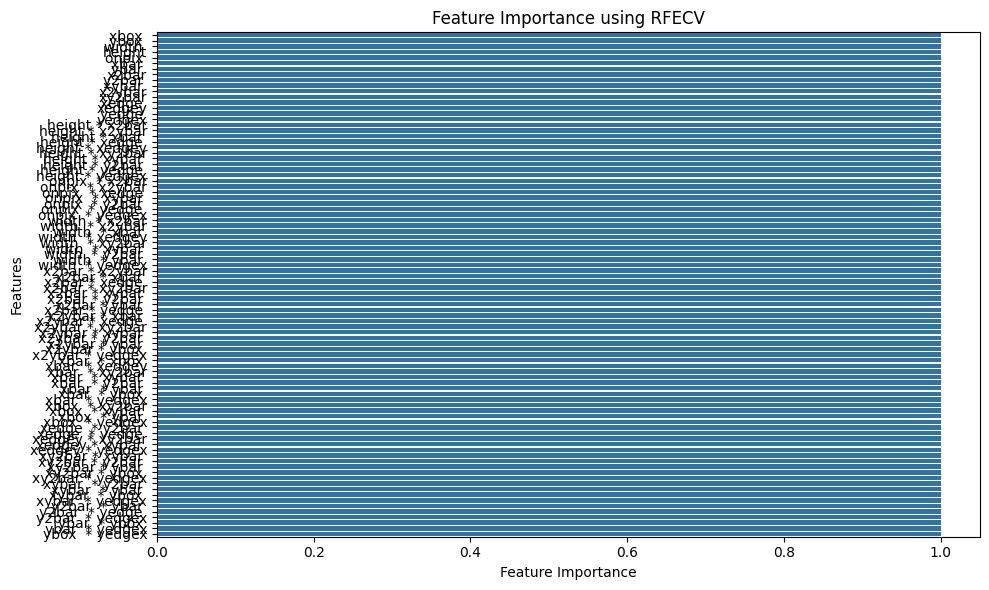

Selected features in X_train:
      xbox      ybox     width     height    onpix      xbar      ybar   \
0  1.555738  2.105906  0.934984  1.162648  0.680462  0.540211  0.641067   
1  1.555738  0.596364  0.934984  0.721342  0.226139 -1.434967  0.641067   
2 -0.008375  0.294455 -0.549215  0.280036  0.226139 -0.447378  0.211865   
3  1.555738  2.407815  0.440251  1.162648  0.680462  0.540211 -0.217337   
4 -0.529745 -1.215087 -0.549215 -0.602575 -0.682506  0.046417 -0.646539   

      x2bar    y2bar     xybar   ...  xybar  * y2bar   xybar  * ybar   \
0 -0.236641 -0.487827  1.501140  ...         0.178730        1.538034   
1 -0.977592  0.770270  0.695794  ...         1.046638        0.921490   
2  1.615735 -0.487827 -0.512225  ...        -0.610278       -0.243094   
3 -0.236641 -0.487827 -0.109552  ...        -0.452476       -0.243094   
4  2.356686 -1.745924 -0.109552  ...        -1.399285       -0.517114   

   xybar  * ybox   xybar  * yedgex  y2bar  * ybar   y2bar  * yedge   \
0        

In [4]:
#All the Functions that 
df= index_label_encode(df,index)
print("Columns after indexing and encoding:")
print(df.columns)
df,data_types = initialize_entityset_for_dtype_handling_and_process(df, 'project_0', 'project_0',index)
print("\nCategorizing columns...")
categorized_columns = categorize_columns(df, data_types)
print("Columns after categorization:")
print(df.columns)
df = columns_to_remove(df, columns_to_drop_input)
print("Columns after removal:")
print(df.columns)
df = remove_single_unique_value_columns_and_high_cardinality(df)
df = missing_values(df, strategy_for_missing_values, categorized_columns['numeric'])
print("Columns after handling missing values:")
print(df.columns)
df = split_columns_wcomma(df,categorized_columns['categorical'])
df = apply_transformations(df, categorized_columns['numeric'])
df = label_encode_target_variable(df,target_variable)
print("Columns after encoding target variable:")
print(df.columns)
df = encoding(df, categorized_columns, cardinality_threshold)
print("Columns after encoding categorical and boolean columns:")
print(df.columns)
df = remove_similar_columns(df, target_variable, threshold_for_correlation)
print("Columns after removing correlated columns:")
print(df.columns)
# df = remove_outliers(df, z_threshold)
df = remove_index_column(df,'MainID','index')
print("Data processing completed successfully")
processed_dataframes = process_tables(tables, df, data_types)
selected_data_frames,target = process_target_variable(processed_dataframes, target_variable)
entity_set=create_entity_set_and_add_relationships(selected_data_frames, tables)
print("Entity set created successfully")
print(entity_set)
target_df = input("Enter the target dataframe for deep feature synthesis: ")
start_time = time.time()
feature_matrix,_=deep_feature_synthesis(entity_set,target_df)
print("Feature matrix created successfully")
print(feature_matrix)
mean_missing_proportion = feature_matrix.isnull().mean().mean() 
cleaned_feature_matrix, dropped_columns = drop_columns_based_on_missing_values(feature_matrix, mean_missing_proportion)
correlated_features = drop_highly_correlated_features(cleaned_feature_matrix, co_threshold=0.9)
cleaned_feature_matrix.drop(columns=correlated_features, inplace=True)
cleaned_feature_matrix.to_csv('cleaned_feature_matrix.csv', index=False)
print("Feature matrix cleaned successfully")
print("Number of columns after dropping noisy columns:", cleaned_feature_matrix.shape[1])
X_train, X_test, y_train, y_test = split_data_for_training(cleaned_feature_matrix, target, random_state=random_state)
X_train, X_test = replace_infinite_values_with_nan(X_train, X_test)
X_train, X_test = impute_missing_values(X_train, X_test)
X_train, X_test = scale_data(X_train, X_test)
# X_train, y_train = remove_outliers(X_train, y_train,outlier_technique=outlier_technique)
X_train_selected, X_test_selected = find_best_feature_selector(X_train, y_train, X_test)
print("Feature selection completed successfully")
end_time = time.time()
print(f"Time taken for the entire process(INCLUDING THE DATA PREPROCESSING & FEATURE SELECTION): {end_time - start_time:.2f} seconds")

### Model Evaluation

In [12]:
# Define list of model pipelines
'''
This list contains different machine learning models that will be evaluated.
'''
model_pipelines = [
    LogisticRegression(solver='liblinear', random_state =42),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    SVC(),
    GaussianNB(),
    XGBClassifier(),
    StackingClassifier(estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC()),
        ('gnb', GaussianNB()),
        ('xgb', XGBClassifier())
    ], final_estimator=LogisticRegression())
]

#Change the y_train which is a dataframe to ravel
y_train=y_train.values.ravel()
y_test=y_test.values.ravel()

# Lists to store metrics
acc_list = []
f1_list = []
pr_list = []
re_list = []
cm_list = []

# Evaluate each model
for model_pipeline in model_pipelines:
    if isinstance(model_pipeline, StackingClassifier):
        model_name = 'StackingClassifier'
    else:
        model_name = model_pipeline.__class__.__name__

    print(f"Evaluating {model_name}...")

    # Fit the model and predict
    model_pipeline.fit(X_train_selected, y_train)
    y_pred = model_pipeline.predict(X_test_selected)

    # Determine if binary or multi-class classification
    unique_classes = np.unique(y_test)
    if len(unique_classes) == 2:  # Binary classification
        average_type = 'binary'
    else:  # Multi-class classification
        average_type = 'weighted'

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=average_type)
    precision = precision_score(y_test, y_pred, average=average_type)
    recall = recall_score(y_test, y_pred, average=average_type)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store metrics
    acc_list.append(acc)
    f1_list.append(f1)
    pr_list.append(precision)
    re_list.append(recall)
    cm_list.append(cm)

    # Display the metrics
    print(f"Accuracy: {acc}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{cm}")
    print("\n")

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [13]:
#result_df
result_df = pd.DataFrame({
    'Model': [model.__class__.__name__ for model in model_pipelines],
    'Accuracy': acc_list,
    'F1 Score': f1_list,
    'Precision': pr_list,
    'Recall': re_list,
    'Confusion Matrix': cm_list
})

result_df

,Model,Accuracy,F1 Score,Precision,Recall,Confusion Matrix
0,LogisticRegression,0.86625,0.866783,0.868758,0.86625,"[[140, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
1,RandomForestClassifier,0.96650,0.966616,0.967251,0.96650,"[[145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,DecisionTreeClassifier,0.84900,0.848930,0.849951,0.84900,"[[136, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 1, ..."
3,KNeighborsClassifier,0.94950,0.949686,0.950497,0.94950,"[[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ..."
4,SVC,0.95350,0.953686,0.954926,0.95350,"[[145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,GaussianNB,0.63375,0.629224,0.654839,0.63375,"[[127, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, ..."
6,XGBClassifier,0.95925,0.959303,0.959753,0.95925,"[[138, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, ..."
7,StackingClassifier,0.95800,0.958042,0.958336,0.95800,"[[142, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, ..."


## Model Evaluation Visualizations

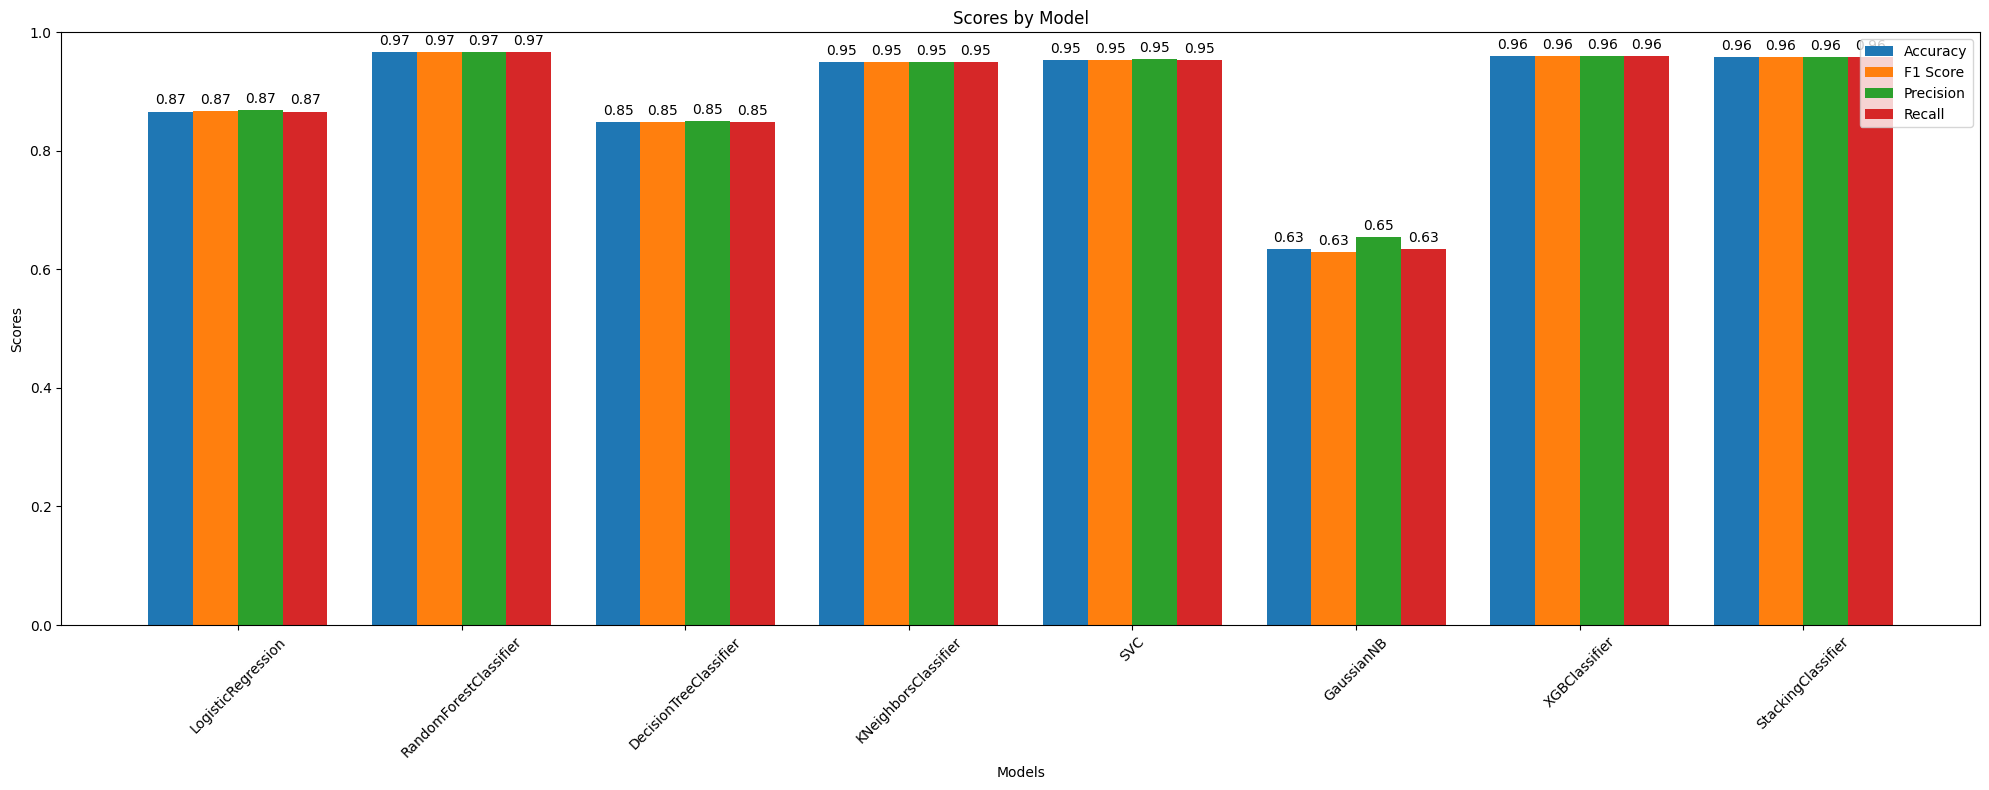

In [14]:
x = np.arange(len(model_pipelines))
width = 0.2 # Width of the bars
 
fig, ax = plt.subplots(figsize=(20, 8))
 
bar1 = ax.bar(x - 1.5 * width, acc_list, width, label='Accuracy')
bar2 = ax.bar(x - 0.5 * width, f1_list, width, label='F1 Score')
bar3 = ax.bar(x + 0.5 * width, pr_list, width, label='Precision')
bar4 = ax.bar(x + 1.5 * width, re_list, width, label='Recall')
 
ax.set_ylim(0, 1.0)
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels([model.__class__.__name__ for model in model_pipelines], rotation=45)
ax.legend()
# Annotate bars
def annotate_bars(bars, labels):
    for bar, label in zip(bars, labels):
        height = bar.get_height()
        ax.annotate(f"{label:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
 
annotate_bars(bar1, acc_list)
annotate_bars(bar2, f1_list)
annotate_bars(bar3, pr_list)
annotate_bars(bar4, re_list)
 
plt.tight_layout()
plt.show()

## AUC-ROC Curve

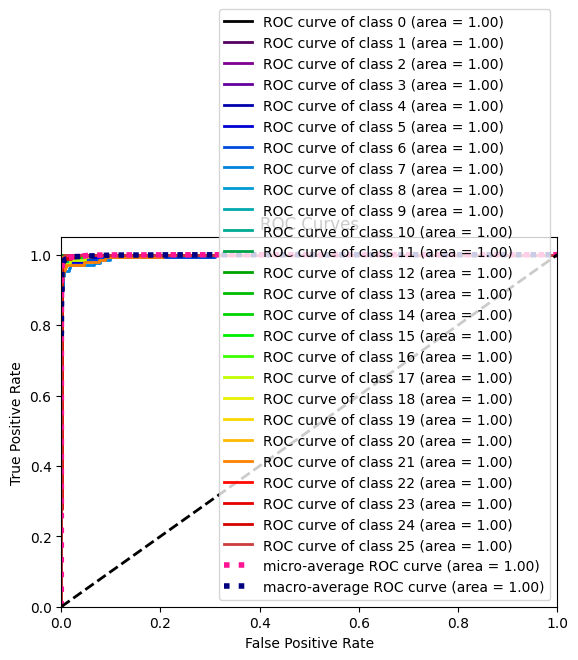

In [15]:
# Plot ROC curve( The ROC curve is a graphical representation of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.)
#Using the scikit-plot library
y_true = y_test
y_probas = model_pipeline.predict_proba(X_test_selected)
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()